In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


### Create dataset

In [2]:
samples = 1500
X, Y = make_circles(samples, noise = 0.04)

In [3]:
X.shape, Y.shape

((1500, 2), (1500,))

In [4]:
# convert to pandas dataframe
df = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], 'Label': Y})

In [5]:
df.head()

,X1,X2,Label
0,-0.517951,-0.838801,0
1,0.196409,-0.755971,1
2,-1.022807,-0.220374,0
3,-1.006099,0.022292,0
4,-0.338342,0.708308,1


In [6]:
# check the distribution of labels
df.Label.value_counts()

Label
0    750
1    750
Name: count, dtype: int64

Nicely balanced dataset, no rare labels.

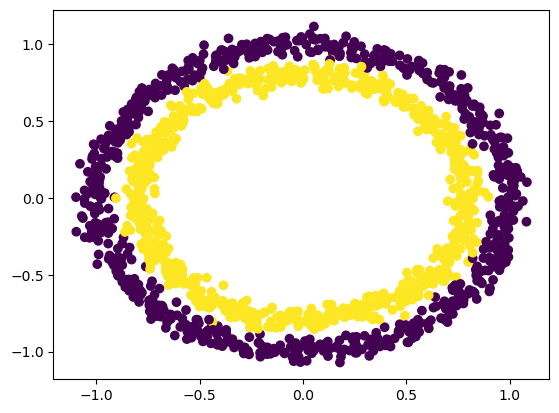

In [7]:
plt.scatter(x = df['X1'], y = df['X2'], c = df["Label"])

In [8]:
type(X)

numpy.ndarray

In [9]:
# convert to torch tensors
X = torch.from_numpy(X).type(torch.FloatTensor)
Y = torch.from_numpy(Y).type(torch.FloatTensor)

In [10]:
type(X), type(Y)

(torch.Tensor, torch.Tensor)

In [11]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y,
                                                    test_size=.20,
                                                    random_state=42)

In [12]:
train_X[:5], train_Y[:5]

(tensor([[-0.7328, -0.1340],
         [-0.4816,  0.9337],
         [-0.5249, -0.6351],
         [-0.6424, -0.5532],
         [-0.0653, -0.9160]]),
 tensor([1., 0., 1., 1., 0.]))

### Build the model

In [13]:
class CircularLinNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features= 6)
        self.layer_2 = nn.Linear(in_features=6, out_features=1)

    def forward(self, X):
        return self.layer_2(self.layer_1(X))
    
# create instance and load on device
model_C = CircularLinNN().to(device)
model_C.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.4740,  0.5605],
                      [-0.4608,  0.5358],
                      [ 0.2029,  0.0872],
                      [-0.5102, -0.1036],
                      [ 0.4110,  0.0525],
                      [-0.6899, -0.6618]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.1847, -0.4687, -0.6517, -0.1653, -0.1402,  0.1980], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0645,  0.0262, -0.1598,  0.2619,  0.2391,  0.0013]],
                     device='cuda:0')),
             ('layer_2.bias', tensor([-0.0318], device='cuda:0'))])

In [14]:
# alternative way of instatiating model
model_seq = nn.Sequential(
    nn.Linear(in_features=2,out_features=6),
    nn.Linear(in_features=6, out_features=1)
).to(device)

In [15]:
model_seq.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0180, -0.2590],
                      [-0.4685,  0.0738],
                      [-0.4388,  0.2433],
                      [ 0.1544, -0.2777],
                      [ 0.0757, -0.5055],
                      [ 0.6510,  0.1345]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6994, -0.1568, -0.3026, -0.1328, -0.4912, -0.5507], device='cuda:0')),
             ('1.weight',
              tensor([[-0.2854, -0.3688,  0.3493, -0.0340,  0.2034,  0.3619]],
                     device='cuda:0')),
             ('1.bias', tensor([-0.0133], device='cuda:0'))])

So we get similar outcomes but the first approach is a lot more customizable

### Make preds with untrained model

In [14]:
with torch.inference_mode():
    pred_Y = model_C(test_X.to(device))     # never forget to send to the device

In [15]:
len(pred_Y), len(test_Y)

(300, 300)

In [16]:
pred_Y[:5], test_Y[:5]

(tensor([[ 0.0336],
         [ 0.0640],
         [ 0.0446],
         [-0.0441],
         [-0.0313]], device='cuda:0'),
 tensor([0., 0., 0., 1., 0.]))

Completely wrong outcomes!!

### Training the model

In [18]:
loss_func = nn.BCEWithLogitsLoss()    # BCE + Sigmoid
opti = torch.optim.SGD(params= model_C.parameters(), lr=.01)

# evaluation metrics

def accuracy_func(y_label, y_pred):
    # how many of the preds are correct
    # .item() → convert tensor scalar to Python number
    return (torch.eq(y_label, y_pred).sum().item()  / len(y_pred)) * 100

In [19]:
model_C.eval()
with torch.inference_mode():
    # raw logit -> out from linear transformation
    y = model_C(test_X.to(device))
    # convert to probs
    y = torch.round(torch.sigmoid(y)).squeeze()
len(y)

300

In [20]:
len(test_Y)

300

In [21]:
epochs = 200

# Put data to target device
# must do this step !!
train_X, train_Y = train_X.to(device), train_Y.to(device)
test_X, test_Y = test_X.to(device), test_Y.to(device)


for epoch in range(epochs):

    model_C.train()
    # 1. forward
    train_logit = model_C(train_X).squeeze()
    train_pred_Y = torch.round(torch.sigmoid(train_logit))

    # 2. calculate loss and accuracy
    train_loss = loss_func(train_logit, train_Y)
    accuracy = accuracy_func(train_Y, pred_Y)

    # 3. set optimizer grad to 0
    opti.zero_grad()

    # 4. backprop
    train_loss.backward()

    # 5. optimizer step
    opti.step()

    model_C.eval()
    with torch.inference_mode():
        test_logit = model_C(test_X).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logit))

        test_loss = loss_func(test_logit, test_Y)
        test_accuracy = accuracy_func(test_Y, test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {accuracy:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%")

        
    

Epoch: 0 | Loss: 0.69361, Accuracy: 0.00% | Test loss: 0.69294, Test acc: 50.00%
Epoch: 10 | Loss: 0.69360, Accuracy: 0.00% | Test loss: 0.69295, Test acc: 49.67%
Epoch: 20 | Loss: 0.69358, Accuracy: 0.00% | Test loss: 0.69296, Test acc: 49.67%
Epoch: 30 | Loss: 0.69356, Accuracy: 0.00% | Test loss: 0.69297, Test acc: 50.00%
Epoch: 40 | Loss: 0.69355, Accuracy: 0.00% | Test loss: 0.69298, Test acc: 50.00%
Epoch: 50 | Loss: 0.69354, Accuracy: 0.00% | Test loss: 0.69298, Test acc: 49.67%
Epoch: 60 | Loss: 0.69352, Accuracy: 0.00% | Test loss: 0.69299, Test acc: 49.67%
Epoch: 70 | Loss: 0.69351, Accuracy: 0.00% | Test loss: 0.69300, Test acc: 49.67%
Epoch: 80 | Loss: 0.69350, Accuracy: 0.00% | Test loss: 0.69301, Test acc: 49.67%
Epoch: 90 | Loss: 0.69348, Accuracy: 0.00% | Test loss: 0.69302, Test acc: 50.00%
Epoch: 100 | Loss: 0.69347, Accuracy: 0.00% | Test loss: 0.69302, Test acc: 50.00%
Epoch: 110 | Loss: 0.69346, Accuracy: 0.00% | Test loss: 0.69303, Test acc: 50.33%
Epoch: 120 | Lo

Without non linearity, the results are not really acceptable. Its as good as randomly guessing